In [226]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import mediapipe as mp
import glob
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [6]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

In [19]:
cap = cv2.VideoCapture(0)
with mp_hands.Hands(
    model_complexity=0,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as hands:
    
    while True:
        _, frame = cap.read()
        frame = processAndDraw(frame)
        cv2.imshow("Frame", cv2.flip(frame, 1))
        
        if cv2.waitKey(1) == 27:
            break;
cv2.destroyAllWindows()
cap.release()

## Reading and Loading images with their labels

I process the images using using google's mediapipe hand detection model and store the detected landmarks to use as my data for each gesture

In [237]:
def loadImages(rootDir):
    imageFiles = {}
    # Traverse through each folder and its subfolders
    count = 0
    for folderPath, _, _ in os.walk(rootDir):
        # Traverse through each folder within the current folder
        if len(glob.glob(os.path.join(folderPath, '*.png'))) > 0:
            if os.path.basename(folderPath).upper() not in imageFiles.keys():
                imageFiles[os.path.basename(folderPath).upper()] = (glob.glob(os.path.join(folderPath, '*.png')))
            else:
                imageFiles[os.path.basename(folderPath).upper()].extend(glob.glob(os.path.join(folderPath, '*.png')))
    return imageFiles


In [244]:
def readImages(files):
    data = []
    labels = []
    with mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=2,
    min_detection_confidence=0.2) as hands:
        # Loop over all images and append their landmarks to the data array
        for key, value in files.items():
            for image in value:
                data_aux= []
                img = cv2.flip(cv2.imread(image), 1)
                # Getting landmarks using mediapipe
                results = hands.process(img)
                if results.multi_hand_landmarks:
                    for landmarks in results.multi_hand_landmarks:
                        for i in range(len(landmarks.landmark)):
                            data_aux.append(landmarks.landmark[i].x)
                            data_aux.append(landmarks.landmark[i].y)
                    data.append(data_aux)
                    labels.append(key)
                    
    return data , labels

In [ ]:
# You skip this cell and load the pickle instead as this takes a long time
images = loadImages('data')
data,labels = readImages(images)

In [321]:
# Storing data in pickle
f = open('handData.pickle','wb')
pickle.dump({'data':data, 'labels':labels}, f)
f.close()

## Training Model

In [212]:
data_dict = pickle.load(open("handData.pickle", 'rb'))
data = np.asarray(data_dict['data'])
labels = np.asarray(data_dict['labels'])

In [220]:
X_train, X_test, y_train, y_test = train_test_split(data,labels, test_size=0.2, stratify=labels, shuffle=True)

In [225]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [228]:
y_predict = model.predict(X_test)
print(accuracy_score(y_predict,y_test))

0.9951325040562466


## Testing on data

In [341]:
def processAndDraw(frame_paths, frame_data, model):
    ax = plt.figure(figsize=(10,10))
    for i,frame in enumerate(frame_paths):
        frame = cv2.imread(frame)
        frame.flags.writeable = False
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        with mp_hands.Hands(
        model_complexity=0,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5) as hands:
            results = hands.process(frame)
            
            if results.multi_hand_landmarks:
              for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(
                    frame,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    mp_drawing_styles.get_default_hand_landmarks_style(),
                    mp_drawing_styles.get_default_hand_connections_style())
    
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            
            plt.subplot(len(frame_paths), 2, i+1)
            plt.yticks([])
            plt.xticks([])
            plt.title(model.predict([frame_data[i]])[0])
            plt.imshow(frame)

In [342]:
# Testing on test folder I made with 4 images
test_images = loadImages('test')
test_data, test_labels = readImages(test_images)

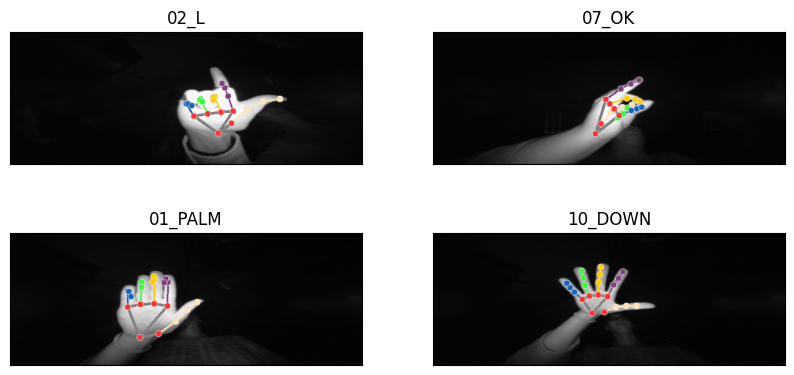

In [343]:
processAndDraw(test_images['TEST'], test_data, model)